In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Read data

In [4]:
calendar = pd.read_feather('/Users/Panot/Desktop/m5/data/calendar.feather')
sales = pd.read_feather('/Users/Panot/Desktop/m5/data/sales_train_validation.feather')
price = pd.read_feather('/Users/Panot/Desktop/m5/data/sell_prices.feather')

In [7]:
calendar.shape

(1969, 14)

In [12]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


Sales is still in wide format

In [8]:
sales.shape

(30490, 1919)

In [11]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [9]:
price.shape

(6841121, 4)

In [21]:
sales_long = pd.melt(sales, 
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='date',
                     value_name='sales')

In [22]:
sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


## EDA 

### Trend/Seasonality Analysis

Here, we'll be looking at category-state level to make visualization look easier

In [62]:
sales_nation = sales_long.groupby(['cat_id', 'date', 'state_id']).agg({'sales':'sum'}).reset_index()

In [63]:
sales_nation =  sales_nation.merge(calendar, left_on = 'date', right_on = 'd', how = 'left')

In [64]:
sales_nation.sort_values(['state_id','cat_id', 'wm_yr_wk'], inplace=True)

In [66]:
sales_nation['date_index'] = sales_nation['d'].replace('d_', '', regex=True).astype('int')

The plot below shows overall sales at category level in three different states.

Key Takeaways: 

- California has the most sales in all categories
- Wisconsin and Texas display similar patterns. 
- Most of the plots display non stationarity, especially for HOUSEHOLD. 
- For Hobbies, there seem to be a huge down trend in 2012 before rebounding back up in 2013. 
- There is definitely seasonality because once a year, there'll be a significant drop in sales towards the end of the year.

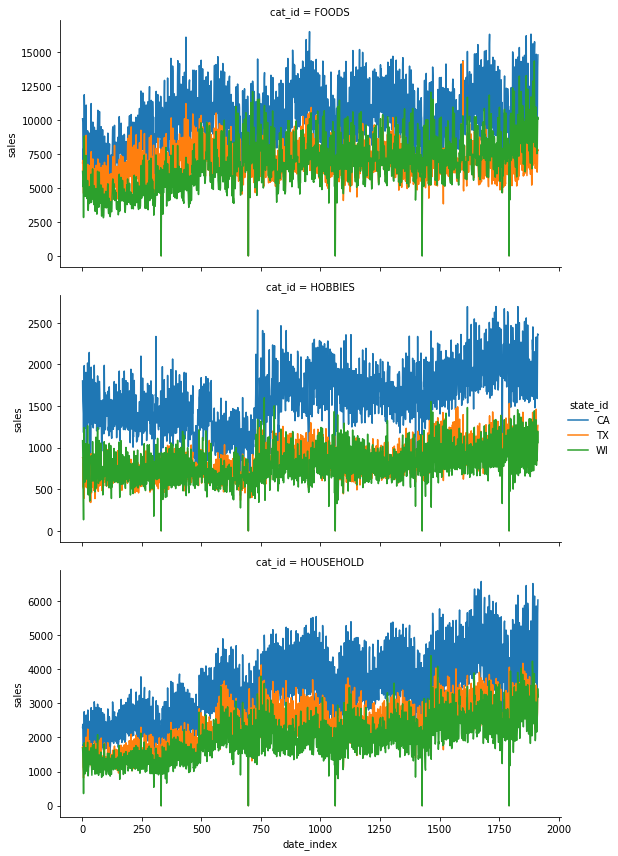

In [74]:
grid = sns.FacetGrid(sales_nation, row='cat_id', hue = 'state_id', height=4, aspect=2, sharey=False)

grid.map(sns.lineplot,
         'date_index',
         'sales')

grid.add_legend()

ACF of each cat-state combination

Since our series are non-stationary, it is important to remove trend from the series first before making plots.
Also, because our series is daily, it can be quite volatile. When looking at acf, we should convert sales into weekly level.

In [93]:
sales_weekly = sales_nation.groupby(['state_id', 'cat_id', 'wm_yr_wk'])['sales'].sum().reset_index()

In [96]:
sales_weekly['diff_sales'] = sales_weekly.groupby(['state_id', 'cat_id'])['sales'].transform(lambda x: x.diff())

The key takeaways for this are that 

- Foods definitely has monthly seasonality, which is expected due to the short life cycle of food. 
- Hobbies doesn't display very clear seasonality in California/Texas but seem to display some kind of seasonality towards the middle of the year.
- Household displays seasonality 2 times a year in California/Texas but interestingly displays monthly seasonality in Wisconsin

Possible features/techniques to generate
- Sum squared auto correlation (monthly/quarterly) for each series
- Segment training data by category-state with high seasonality

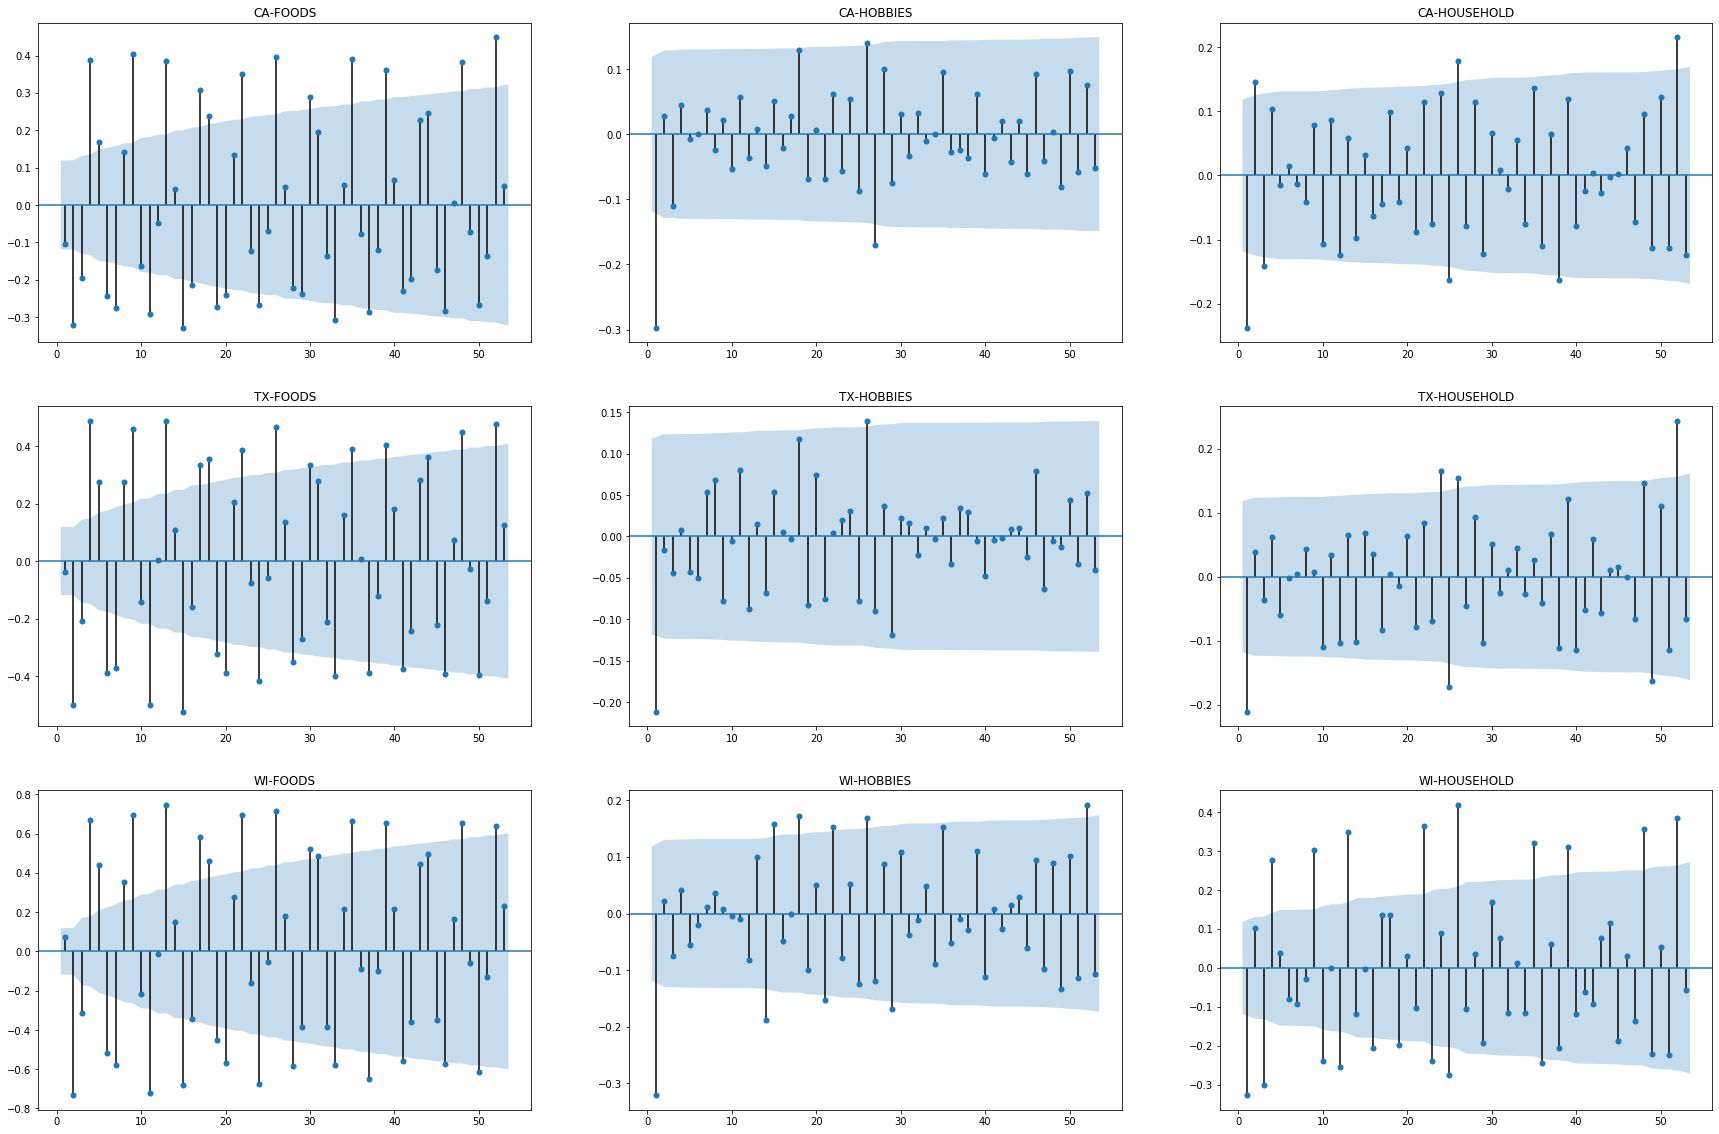

In [116]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))

for i,state in enumerate(sales_weekly.state_id.unique()):
    for j,cat in enumerate(sales_weekly.cat_id.unique()):\
        plot_acf(sales_weekly.loc[(sales_weekly.state_id == state) & (sales_weekly.cat_id == cat), 'diff_sales'], 
                 ax=ax[i,j], 
                 lags=53, 
                 missing='drop',
                 title=f'{state}-{cat}',
                 zero=False)

Day of week analysis

Day-of-week is usually the go-to feature when forecasting at daily level.

In [118]:
sales_nation['weekend'] = np.where(sales_nation.wday <= 2, 1, 0)

In [119]:
sales_dow = sales_nation.groupby(['cat_id', 'state_id', 'weekday'])['sales'].agg('sum').reset_index()

Key takeaways:
It is clear that sales is highest during the weekend, but there is a slight offtake starting on Friday. Sales start to decline on Monday and sales from Tuesday-Thursday seem to remain constant.

Features to generate:
Convolution feature based on this finding.

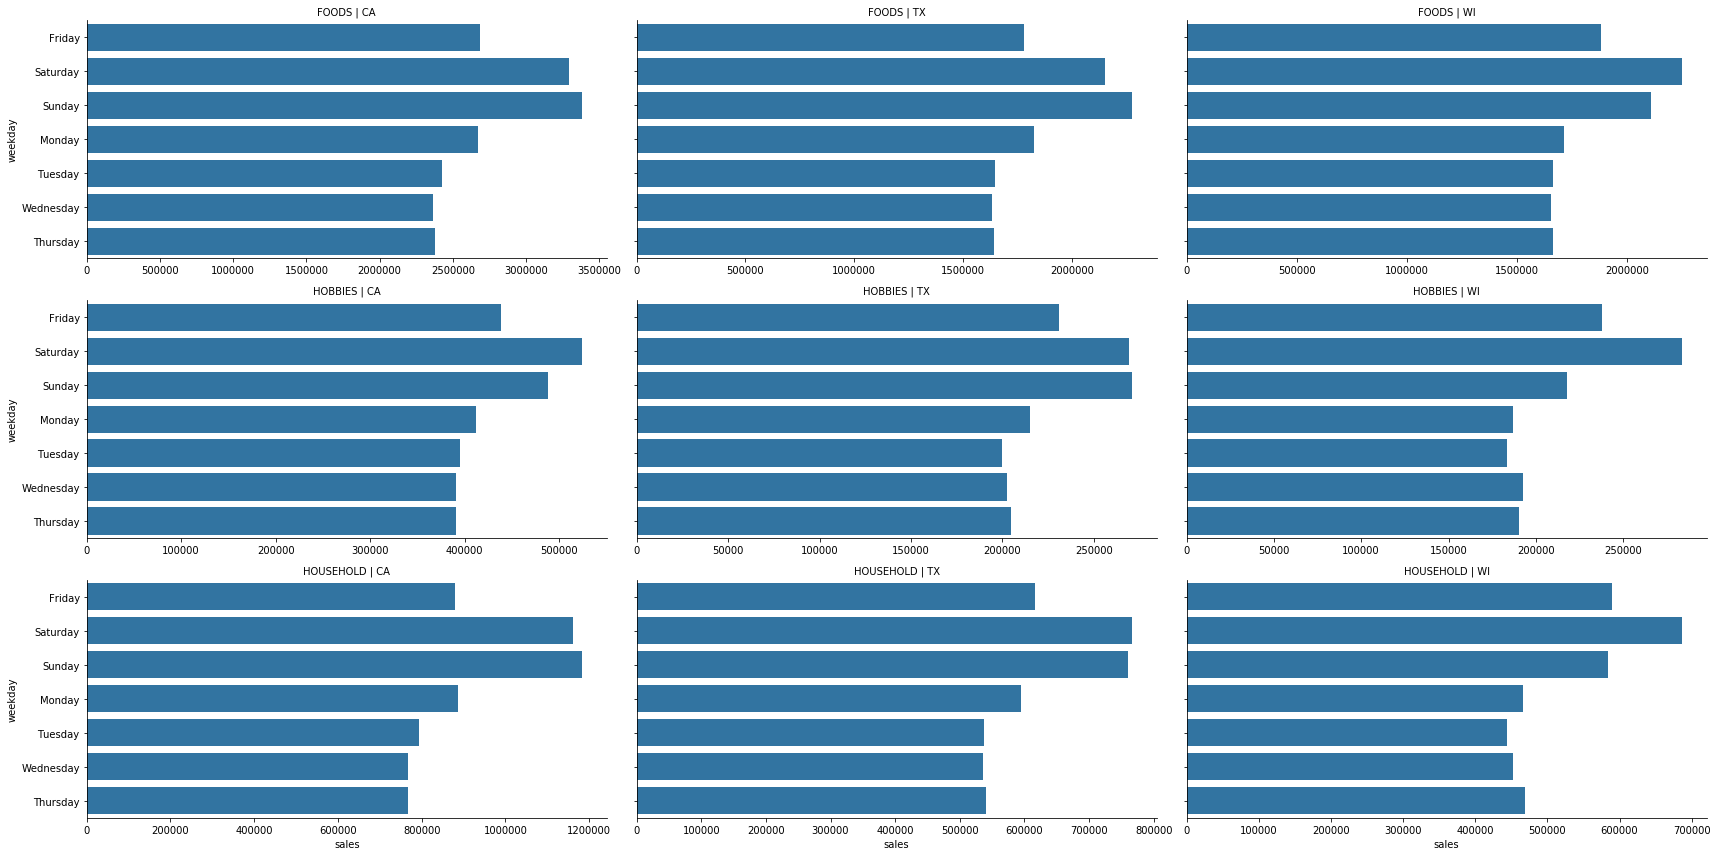

In [128]:
grid = sns.FacetGrid(sales_dow, row='cat_id', col='state_id', height=4, aspect=2, sharex=False)

grid.map(sns.barplot,
         'sales',
         'weekday',
         order=['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])

grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.add_legend()

### Promotion Analysis

When a customer looks at what to buy, an important factor is looking at the selling price. In this section, I'll be performing analysis on how much uplift promotions generate.

In [ ]:
sales_promo = (sales_nation
               .groupby(['store_id', 'item_id', 'state_id', 'cat_id', 'wm_yr_wk'])['sales']
               .sum()
               .reset_index()
               .merge(price, 
                      on=['store_id', 'item_id', 'wm_yr_wk'],
                      how='left'))

In [129]:
sales_nation.head()

,cat_id,date_x,state_id,sales,date_y,wm_yr_wk,weekday,wday,month,year,...,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,date_index,diff_sales,weekend
0,FOODS,d_1,CA,10101,2011-01-29,11101,Saturday,1,1,2011,...,None,None,None,None,0,0,0,1,NaN,1
3075,FOODS,d_2,CA,9862,2011-01-30,11101,Sunday,2,1,2011,...,None,None,None,None,0,0,0,2,-239.0,1
3408,FOODS,d_3,CA,6944,2011-01-31,11101,Monday,3,1,2011,...,None,None,None,None,0,0,0,3,-2918.0,0
3741,FOODS,d_4,CA,7864,2011-02-01,11101,Tuesday,4,2,2011,...,None,None,None,None,1,1,0,4,920.0,0
4074,FOODS,d_5,CA,7178,2011-02-02,11101,Wednesday,5,2,2011,...,None,None,None,None,1,0,1,5,-686.0,0
